In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from numpy.typing import NDArray
from scipy.optimize import minimize
from typing import Tuple

In [73]:
# 価格を生成する関数
def create_price(r_mean: float, r_std: float, M: int) -> NDArray[np.float_]:
    # r_mean = (r_min + r_max) / 2
    # r_std = (r_max - r_mean) / 2
    # r_minとr_maxの間のランダムな0.1刻みの少数をM個生成
    price = np.random.normal(r_mean, r_std, size=M)
    # price = np.round(price, 1)

    return price


# alphaを作成する関数
def alpha_star(M: int) -> NDArray[np.float_]:
    alpha_star = np.random.uniform(M, 3 * M, size=M)
    return alpha_star


# betaを作成する関数
def beta_star(M: int, M_prime: int) -> NDArray[np.float_]:
    beta_star = np.zeros((M, M_prime))

    for m in range(M):
        for m_prime in range(M_prime):
            if m == m_prime:
                beta_star[m, m_prime] = np.random.uniform(-3 * M, -2 * M)
            else:
                beta_star[m, m_prime] = np.random.uniform(0, 3)

    return beta_star


def quantity_function(
    price: NDArray[np.float_],
    alpha: NDArray[np.float_],
    beta: NDArray[np.float_],
    delta: float = 0.1,  # ノイズレベルを指定（例として0.1を使用）
) -> list[float]:
    M = len(price)
    quantity_list = []
    q_m_no_noise = []

    # ステップ1: ノイズなしのq_mを計算
    for m in range(M):
        sum_beta = 0
        for m_prime in range(M):
            sum_beta += beta[m][m_prime] * price[m_prime]
        quantity = alpha[m] + sum_beta
        q_m_no_noise.append(quantity)

    # E[q_m^2]を計算
    E_q_m_squared = np.mean(np.array(q_m_no_noise) ** 2)

    # ステップ2: ノイズの標準偏差sigmaを計算
    sigma = delta * np.sqrt(E_q_m_squared)

    # ステップ3: ノイズを加えて最終的なq_mを計算
    for m in range(M):
        epsilon = np.random.normal(0, sigma)
        quantity = q_m_no_noise[m] + epsilon
        quantity_list.append(quantity)

    return quantity_list


def sales_function(
    price: NDArray[np.float_], alpha: NDArray[np.float_], beta: NDArray[np.float_]
) -> list[float]:
    M = len(price)
    sales_list = []

    for m in range(M):
        sum_beta = 0
        for m_prime in range(M):
            sum_beta += beta[m][m_prime] * price[m_prime]

        quantity = alpha[m] + sum_beta
        sales_list.append(quantity * price[m])

    return sales_list


def create_date(M, N, r_mean, r_std, delta=0.1):
    alpha = alpha_star(M)
    beta = beta_star(M, M)

    price_list = []
    quantity_list = []

    for _ in range(N):
        price = create_price(r_mean, r_std, M)
        quantity = quantity_function(price, alpha, beta, delta)
        price_list.append(price)
        quantity_list.append(quantity)

    X = np.array(price_list)
    Y = np.array(quantity_list)

    return alpha, beta, X, Y


def create_bounds(M, r_min, r_max):
    lb = np.full(M, r_min)
    ub = np.full(M, r_max)

    bounds = []
    for i in range(M):
        bounds.append(lb[i] - 0.1)

    for i in range(M):
        bounds.append(ub[i] + 0.1)

    default_bounds = [(r_min, r_max) for _ in range(M)]

    return lb, ub, bounds, default_bounds

In [4]:
# 目的関数を定義（最大化問題を最小化問題に変換）
def sales_objective_function(prices, alpha, beta, M):
    return -sum(
        prices[m] * (alpha[m] + sum(beta[m][m_prime] * prices[m_prime] for m_prime in range(M)))
        for m in range(M)
    )


def sales_optimize(
    M: int,
    alpha: np.ndarray,
    beta: np.ndarray,
    bounds: list[tuple[float, float]],
) -> Tuple[float, np.ndarray]:
    # 初期値として与えられたprices_listを使用
    initial_prices = np.full(M, 0.6)

    # 最適化を実行
    result = minimize(
        sales_objective_function,
        initial_prices,
        args=(alpha, beta, M),
        bounds=bounds,
        method="L-BFGS-B",
    )
    # 最適な価格と目的関数の値を取得
    optimal_prices = result.x
    optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す
    return optimal_value, optimal_prices

In [5]:
# 目的関数を定義
def predict_objective_function(
    prices: NDArray[np.float_], intercepts: [float], coefs: [NDArray[np.float_]], M: int
) -> float:
    # 各変数の内容をデバッグ出力
    # print("prices:", prices)
    # print("intercepts:", intercepts)
    # print("coefs:", coefs)
    # print("M:", M)

    return -sum(
        prices[m]
        * (intercepts[m] + sum(coefs[m][m_prime] * prices[m_prime] for m_prime in range(M)))
        for m in range(M)
    )


# 予測と最適化を行う関数
def predict_optimize(
    M: int, X: NDArray[np.float_], Y: NDArray[np.float_], bounds: list[float]
) -> tuple[float, NDArray[np.float_]]:
    lr = MultiOutputRegressor(LinearRegression())
    lr.fit(X, Y)
    # 係数と切片を取得
    coefs = [estimate.coef_ for estimate in lr.estimators_]
    intercepts = [estimate.intercept_ for estimate in lr.estimators_]

    # 初期値として与えられたprices_listを使用
    initial_prices = np.full(M, 0.6)
    # 最適化を実行
    result = minimize(
        predict_objective_function,
        initial_prices,
        args=(intercepts, coefs, M),
        bounds=bounds,
        method="L-BFGS-B",
    )
    # 最適な価格と目的関数の値を取得
    optimal_prices = result.x
    optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す
    return optimal_value, optimal_prices

In [6]:
# CVを行う関数
def cross_validation(
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    M: int,
    K: int,
    bounds: list[float],
) -> float:
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        # 初期値として与えられたprices_listを使用
        initial_prices = np.full(M, 0.6)

        # 最適化を実行
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts, coefs, M),
            bounds=bounds,
            method="L-BFGS-B",
        )
        # 最適な価格と目的関数の値を取得
        optimal_prices = result.x

        # testで学習
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        quantity_hat = lr_hat.predict([optimal_prices])
        sales_hat = np.sum(quantity_hat * optimal_prices)

        optimal_sales_list.append(sales_hat)

    return np.mean(optimal_sales_list)

In [7]:
M = 10
N = 500
K = 5
r_min = 0.6
r_max = 1.0
r_mean = 0.8
r_std = 0.1

lb, ub, bounds, default_bounds = create_bounds(M, r_min, r_max)

In [27]:
so_salse_list = []
po_salse_list = []
true_po_salse_list = []
cv_salse_list = []

for _ in range(100):
    # データ作成
    alpha, beta, X, Y = create_date(M, N, r_mean, r_std, delta=1.0)  # 最適化
    so_sales, so_prices = sales_optimize(M, alpha, beta, default_bounds)
    po_sales, po_prices = predict_optimize(M, X, Y, default_bounds)
    true_po_sales = sum(sales_function(po_prices, alpha, beta))
    cv_sales = cross_validation(X, Y, M, K, default_bounds)

    print("so", so_prices)
    print("po", po_prices)
    print(so_prices == po_prices)

    so_salse_list.append(so_sales / so_sales)
    po_salse_list.append(po_sales / so_sales)
    true_po_salse_list.append(true_po_sales / so_sales)
    cv_salse_list.append(cv_sales / so_sales)

so [0.88985772 0.90655339 1.         1.         1.         0.6
 0.6        1.         0.6        0.72753109]
po [0.6        1.         1.         0.72679621 1.         0.6
 0.6        0.6        0.62907324 0.68254168]
[False False  True False  True  True  True False False False]
so [1.         1.         1.         0.77850429 1.         0.99476319
 1.         0.85108065 1.         0.98846581]
po [1.         0.97576789 1.         0.6        1.         0.70987306
 1.         0.81034196 1.         0.6       ]
[ True False  True False  True False  True False  True False]
so [1.         1.         1.         0.99853205 1.         1.
 1.         0.87738391 0.62314895 0.85940177]
po [0.88308016 0.6        1.         1.         0.85397955 1.
 1.         0.85690858 0.6        0.96854842]
[False False  True False False  True  True False False False]
so [0.71787069 1.         0.97906284 0.87549501 0.75975132 0.79311451
 0.97204928 0.69340639 0.89690406 1.        ]
po [0.74737267 1.         1.    

In [28]:
so_salse_mean = np.mean(so_salse_list)
po_salse_mean = np.mean(po_salse_list)
true_po_salse_mean = np.mean(true_po_salse_list)
cv_salse_mean = np.mean(cv_salse_list)

In [29]:
label_list = [
    r"$f(z^*,\theta^*)$",
    r"$f(\hat{z},\hat\theta)$",
    r"$f(\hat{z},\theta^*)$",
    r"cv",
]

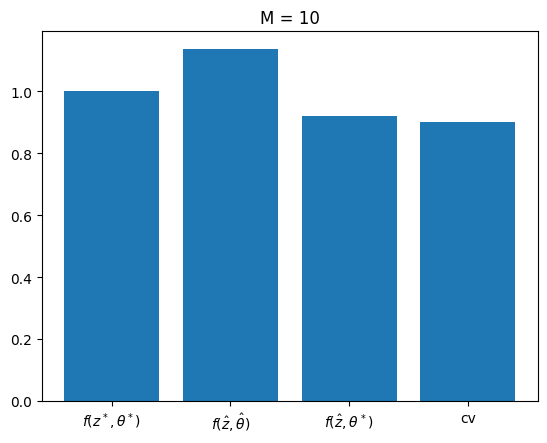

In [30]:
date_list = [so_salse_mean, po_salse_mean, true_po_salse_mean, cv_salse_mean]

# 棒グラフを出力
plt.bar(label_list, date_list)
# plt.yscale("log")
plt.title("M = 10")
plt.show()

In [12]:
M = 20
lb, ub, bounds, default_bounds = create_bounds(M, r_min, r_max)
so_salse_list = []
po_salse_list = []
true_po_salse_list = []
cv_salse_list = []

for _ in range(100):
    # データ作成
    alpha, beta, X, Y = create_date(M, N, r_mean, r_std, delta=1.0)  # 最適化
    so_sales, so_prices = sales_optimize(M, alpha, beta, default_bounds)
    po_sales, po_prices = predict_optimize(M, X, Y, default_bounds)
    true_po_sales = sum(sales_function(po_prices, alpha, beta))
    cv_sales = cross_validation(X, Y, M, K, default_bounds)

    print("so", so_prices)
    print("po", po_prices)
    print(so_prices == po_prices)

    so_salse_list.append(so_sales / so_sales)
    po_salse_list.append(po_sales / so_sales)
    true_po_salse_list.append(true_po_sales / so_sales)
    cv_salse_list.append(cv_sales / so_sales)

so_salse_mean = np.mean(so_salse_list)
po_salse_mean = np.mean(po_salse_list)
true_po_salse_mean = np.mean(true_po_salse_list)
cv_salse_mean = np.mean(cv_salse_list)


so [0.6        0.82347878 0.76074492 0.66292423 0.62982034 0.70128407
 0.79350425 0.64938657 0.90527907 0.65922484 0.6        0.7370605
 0.68844546 0.93237758 0.6        0.6        0.6        0.67000805
 0.6        0.66673649]
po [0.6        1.         0.8349996  0.6        0.6        0.63869675
 1.         0.6        1.         0.6        0.6        0.6
 0.6        1.         0.91052134 0.6        0.6        0.6
 0.6        0.67249858]
[ True False False False False False False False False False  True False
 False False False  True  True False  True False]
so [0.68539109 0.84203844 0.6        0.70961426 0.6        0.72763157
 0.91622245 0.78559922 0.62781679 0.62909577 0.6        0.87443896
 0.6        0.74583722 0.82619334 0.70253937 0.75990771 0.78746607
 0.70589906 0.70771538]
po [1.         0.6        0.6726728  1.         0.6        0.6
 1.         1.         0.6        0.79873297 0.6        0.6
 0.6        0.73840231 1.         0.6        0.79629789 1.
 0.97440853 0.6       ]
[F

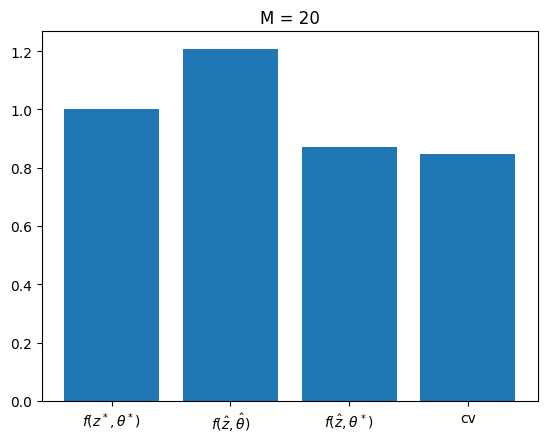

In [13]:
date_list = [so_salse_mean, po_salse_mean, true_po_salse_mean, cv_salse_mean]

# 棒グラフを出力
plt.bar(label_list, date_list)
# plt.yscale("log")
plt.title("M = 20")
plt.show()


In [14]:
M = 30
lb, ub, bounds, default_bounds = create_bounds(M, r_min, r_max)
so_salse_list = []
po_salse_list = []
true_po_salse_list = []
cv_salse_list = []

for _ in range(100):
    # データ作成
    alpha, beta, X, Y = create_date(M, N, r_mean, r_std, delta=1.0)  # 最適化
    so_sales, so_prices = sales_optimize(M, alpha, beta, default_bounds)
    po_sales, po_prices = predict_optimize(M, X, Y, default_bounds)
    true_po_sales = sum(sales_function(po_prices, alpha, beta))
    cv_sales = cross_validation(X, Y, M, K, default_bounds)

    print("so", so_prices)
    print("po", po_prices)
    print(so_prices == po_prices)

    so_salse_list.append(so_sales / so_sales)
    po_salse_list.append(po_sales / so_sales)
    true_po_salse_list.append(true_po_sales / so_sales)
    cv_salse_list.append(cv_sales / so_sales)

so_salse_mean = np.mean(so_salse_list)
po_salse_mean = np.mean(po_salse_list)
true_po_salse_mean = np.mean(true_po_salse_list)
cv_salse_mean = np.mean(cv_salse_list)


so [0.65252362 0.75466408 0.6        0.79987316 0.93636469 0.6
 0.6        0.75418575 0.6        0.6        0.6        0.87452658
 0.70595987 0.88255818 0.89335972 0.76834816 0.6        0.90476817
 0.78421355 0.60188091 0.76288021 0.6        0.77937544 0.60017368
 0.6        0.6        0.92723917 0.60092008 0.6        0.78920343]
po [0.6        1.         0.6        0.73778922 1.         0.65149843
 0.62963027 0.6        0.6        0.85542945 1.         0.62104905
 1.         0.89543048 1.         0.6        0.96381939 0.79541513
 1.         0.6        0.6        0.6        0.6        0.6
 0.6        1.         1.         0.6        0.7408444  1.        ]
[False False  True False False False False False  True False False False
 False False False False False False False False False  True False False
  True False False False False False]
so [0.6386533  0.89190179 0.60327835 0.6        0.7699294  0.6
 1.         0.6        0.6        0.64681359 0.6        0.6
 0.6        0.6        0.6967

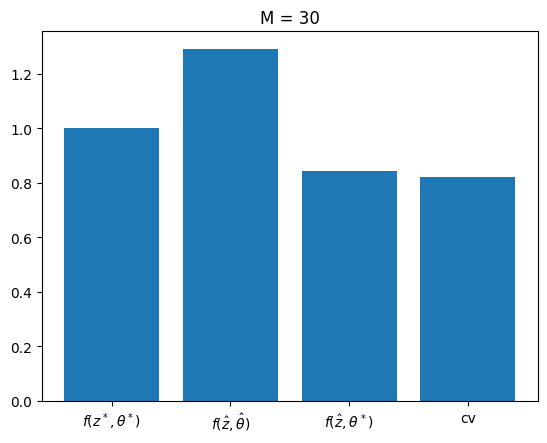

In [15]:
date_list = [so_salse_mean, po_salse_mean, true_po_salse_mean, cv_salse_mean]

# 棒グラフを出力
plt.bar(label_list, date_list)
# plt.yscale("log")
plt.title("M = 30")
plt.show()


so [0.6964349  0.6        0.6        0.60864344 0.6        0.62717461
 0.6        0.69519598 0.6        0.6        0.6        0.6
 0.91851131 0.8561645  0.61807899 0.73227588 0.8331586  0.6
 0.6        0.6        0.78017047 0.88943482 0.64895845 0.6
 0.6        0.82680266 0.73674208 0.6        0.6        0.6
 0.65618365 0.6        0.65921989 0.75869074 0.63691549 0.67936322
 0.6        0.74260623 0.6        0.6       ]
po [0.6        0.6        1.         0.6        0.6        1.
 0.681193   0.6        0.6        0.75763865 1.         0.73034568
 0.86311315 0.64914231 0.6        0.6        0.6        0.6
 0.73602344 0.65615481 0.6        0.81082295 0.6        1.
 1.         1.         0.6        0.9705734  0.6        1.
 0.6        0.6        0.74100726 0.70246167 1.         0.6
 1.         0.6        0.6        0.77087232]
[False  True False False  True False False False  True False False False
 False False False False False  True False False False False False False
 False False False

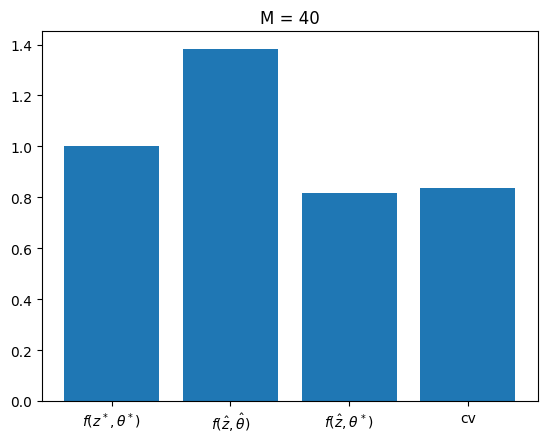

In [16]:
M = 40
lb, ub, bounds, default_bounds = create_bounds(M, r_min, r_max)
so_salse_list = []
po_salse_list = []
true_po_salse_list = []
cv_salse_list = []

for _ in range(100):
    # データ作成
    alpha, beta, X, Y = create_date(M, N, r_mean, r_std, delta=1.0)  # 最適化
    so_sales, so_prices = sales_optimize(M, alpha, beta, default_bounds)
    po_sales, po_prices = predict_optimize(M, X, Y, default_bounds)
    true_po_sales = sum(sales_function(po_prices, alpha, beta))
    cv_sales = cross_validation(X, Y, M, K, default_bounds)

    print("so", so_prices)
    print("po", po_prices)
    print(so_prices == po_prices)

    so_salse_list.append(so_sales / so_sales)
    po_salse_list.append(po_sales / so_sales)
    true_po_salse_list.append(true_po_sales / so_sales)
    cv_salse_list.append(cv_sales / so_sales)

so_salse_mean = np.mean(so_salse_list)
po_salse_mean = np.mean(po_salse_list)
true_po_salse_mean = np.mean(true_po_salse_list)
cv_salse_mean = np.mean(cv_salse_list)


date_list = [so_salse_mean, po_salse_mean, true_po_salse_mean, cv_salse_mean]

# 棒グラフを出力
plt.bar(label_list, date_list)
# plt.yscale("log")
plt.title("M = 40")
plt.show()


In [40]:
# CVを行う関数
def cross_validation_bounds_zero(
    bounds: list[float],
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    M: int,
    K: int,
) -> float:
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []

    bounds_list = []

    for i in range(M):
        if bounds[i] > bounds[i + M]:
            return 0

        else:
            bounds_list.append((bounds[i], bounds[i + M]))

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        # 初期値として与えられたprices_listを使用
        initial_prices = np.full(M, 0.6)
        # 各価格の範囲を設定（0.6から1.0）

        # 最適化を実行
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts, coefs, M),
            bounds=bounds_list,
            method="L-BFGS-B",
        )
        # 最適な価格と目的関数の値を取得
        optimal_prices = result.x

        # testで学習
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        quantity_hat = lr_hat.predict([optimal_prices])
        sales_hat = np.sum(quantity_hat * optimal_prices)

        optimal_sales_list.append(sales_hat)

    return -np.mean(optimal_sales_list)


def estimate_bounds_zero_nelder(bounds, M, X, y, K, r_min, r_max, adaptive=True):
    bounds_nelder = minimize(
        cross_validation_bounds_zero,
        bounds,
        args=(X, y, M, K),
        method="Nelder-Mead",
        bounds=[(r_min - 0.1, r_max + 0.1) for _ in range(2 * M)],
        options={"adaptive": adaptive},
    )

    opt_bounds = []
    for i in range(M):
        opt_bounds.append((bounds_nelder.x[i], bounds_nelder.x[i + M]))

    return -bounds_nelder.fun, opt_bounds

In [8]:
# CVを行う関数
def cross_validation_bounds_penalty(
    bounds: list[float],
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    M: int,
    K: int,
) -> float:
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []

    bounds_list = []

    for i in range(M):
        if bounds[i] > bounds[i + M]:
            penalty = 0
            for i in range(M):
                penalty += bounds[i] ** 2 + bounds[i + M] ** 2
            return penalty

        else:
            bounds_list.append((bounds[i], bounds[i + M]))

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        # 初期値として与えられたprices_listを使用
        initial_prices = np.full(M, 0.6)
        # 各価格の範囲を設定（0.6から1.0）

        # 最適化を実行
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts, coefs, M),
            bounds=bounds_list,
            method="L-BFGS-B",
        )
        # 最適な価格と目的関数の値を取得
        optimal_prices = result.x

        # testで学習
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        quantity_hat = lr_hat.predict([optimal_prices])
        sales_hat = np.sum(quantity_hat * optimal_prices)

        optimal_sales_list.append(sales_hat)

    return -np.mean(optimal_sales_list)


def estimate_bounds_penalty_nelder(bounds, M, X, y, K, r_min, r_max, adaptive=True):
    bounds_nelder = minimize(
        cross_validation_bounds_zero,
        bounds,
        args=(X, y, M, K),
        method="Nelder-Mead",
        bounds=[(r_min, r_max) for _ in range(2 * M)],
        options={"adaptive": adaptive},
    )

    opt_bounds = []
    for i in range(M):
        opt_bounds.append((bounds_nelder.x[i], bounds_nelder.x[i + M]))

    return -bounds_nelder.fun, opt_bounds

In [60]:
M = 5
N = 500
K = 5
r_min = 0.6
r_max = 1.0
r_mean = 0.8
r_std = 0.1

lb, ub, bounds, default_bounds = create_bounds(M, r_min, r_max)
so_bounds = [(0.5, 1.1) for _ in range(M)]

In [61]:
so_bounds

[(0.5, 1.1), (0.5, 1.1), (0.5, 1.1), (0.5, 1.1), (0.5, 1.1)]

In [72]:
default_bounds

[(0.6, 1.0), (0.6, 1.0), (0.6, 1.0), (0.6, 1.0), (0.6, 1.0)]

In [83]:
bounds

[0.5, 0.5, 0.5, 0.5, 0.5, 1.1, 1.1, 1.1, 1.1, 1.1]

In [74]:
so_salse_list = []
po_salse_list = []
true_po_salse_list = []
cv_salse_list = []
ebz_val_list = []
ebz_po_salse_list = []
true_ebz_po_salse_list = []
for _ in range(10):
    # データ作成
    alpha, beta, X, Y = create_date(M, N, r_mean, r_std, delta=0.6)
    # 最適化
    so_sales, so_prices = sales_optimize(M, alpha, beta, default_bounds)
    po_sales, po_prices = predict_optimize(M, X, Y, default_bounds)
    true_po_sales = sum(sales_function(po_prices, alpha, beta))
    cv_sales = cross_validation(X, Y, M, K, default_bounds)
    print("so", so_prices)

    ebz_val, ebz_bounds = estimate_bounds_zero_nelder(
        bounds, M, X, Y, K, r_min, r_max, adaptive=True
    )
    ebz_po_sales, ebz_po_prices = predict_optimize(M, X, Y, ebz_bounds)
    true_ebz_po_sales = sum(sales_function(ebz_po_prices, alpha, beta))

    so_salse_list.append(so_sales / so_sales)
    po_salse_list.append(po_sales / so_sales)
    true_po_salse_list.append(true_po_sales / so_sales)
    cv_salse_list.append(cv_sales / so_sales)
    ebz_val_list.append(ebz_val / so_sales)
    ebz_po_salse_list.append(ebz_po_sales / so_sales)
    true_ebz_po_salse_list.append(true_ebz_po_sales / so_sales)
    print("ebz", ebz_po_prices)
    print(ebz_bounds)

so [0.6        0.81991275 0.74506463 0.71298033 0.6       ]
ebz [0.69968238 0.77331995 0.75643485 0.67609026 0.64569529]
[(0.5000904554274129, 1.0996302299424168), (0.5000965405030929, 1.0999999999999992), (0.5001045915372199, 1.0875157274796639), (0.500679381164987, 1.0565142033048651), (0.5001374476648711, 1.099782484887677)]
so [0.74365776 1.         1.         0.97180217 0.92983306]
ebz [0.67814823 0.91783592 0.80657556 0.81558525 0.76219493]
[(0.5225517367922807, 1.1), (0.5213249398282448, 0.9178359173571221), (0.5203727087249405, 1.080474159274039), (0.5115033497022066, 1.0858474615323441), (0.5086414127970826, 1.0743015848557347)]
so [0.8888276  0.74068557 0.71893959 0.84462327 0.81966387]
ebz [0.8623272  0.77823202 0.5633319  0.92980789 0.95336435]
[(0.5392409029964511, 1.0755579758392741), (0.536274400972984, 1.0999999999999996), (0.5633318977789514, 1.0607730411807055), (0.5276712520102338, 0.9298078870247656), (0.5234848530280611, 0.9533643504234324)]
so [0.60145845 0.664039

In [75]:
so_salse_mean = np.mean(so_salse_list)
po_salse_mean = np.mean(po_salse_list)
true_po_salse_mean = np.mean(true_po_salse_list)
cv_salse_mean = np.mean(cv_salse_list)
ebz_val_mean = np.mean(ebz_val_list)
ebz_po_salse_mean = np.mean(ebz_po_salse_list)
true_ebz_po_salse_mean = np.mean(true_ebz_po_salse_list)

In [76]:
label_list = [
    r"$f(z^*,\theta^*)$",
    r"$f(\hat{z},\hat\theta)$",
    r"$f(\hat{z},\theta^*)$",
    r"cv",
    r"optimazie cv",
    r"$f(\bar{z},\bar\theta)$",
    r"$f(\bar{z},\theta^*)$",
]

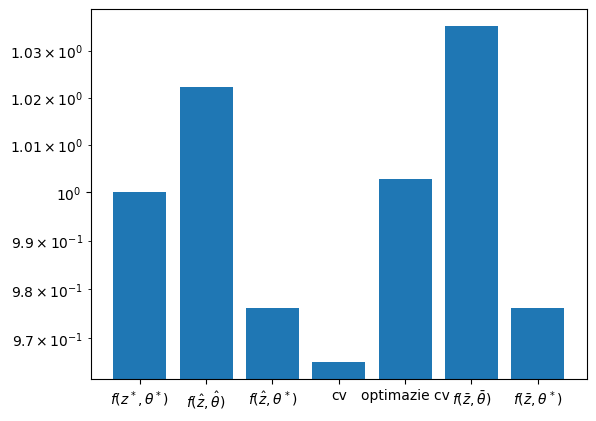

In [77]:
# 結果を棒グラフに出力
date_list = [
    so_salse_mean,
    po_salse_mean,
    true_po_salse_mean,
    cv_salse_mean,
    ebz_val_mean,
    ebz_po_salse_mean,
    true_ebz_po_salse_mean,
]

plt.bar(label_list, date_list)
plt.yscale("log")
plt.show()

In [78]:
for i in range(10):
    print(true_po_salse_list[i], true_ebz_po_salse_list[i])
    print(true_po_salse_list[i] < true_ebz_po_salse_list[i])

0.9829659171517159 0.9829659918260967
True
0.9630892973249251 0.9521960398894703
False
0.9634161007122324 0.9714654494934731
True
0.9913964698245561 0.9913964922397523
True
0.9694796440092897 0.9844721253263949
True
0.9767696585937576 0.9603947975772921
False
0.9746882381808932 0.9790171767511988
True
0.9821284325808473 0.9148195531043741
False
0.9707465185086505 1.0435753127356564
True
0.9869206668192053 0.9803364327353228
False


In [79]:
po_salse_mean

1.0223551802642672

In [82]:
true_po_salse_mean < true_ebz_po_salse_mean

False

In [63]:
ebz_bounds

[(0.5122449422543152, 1.069049432423743),
 (0.5109448669734964, 1.0879729023452027),
 (0.5, 1.0844142743454208),
 (0.5091581585463676, 1.092796277698439),
 (0.5278840984148279, 1.0896247490851112)]

In [18]:
M = 5
N = 250
K = 5
r_min = 0.6
r_max = 1.0
r_mean = 0.8
r_std = 0.1

lb, ub, bounds, default_bounds = create_bounds(M, r_min, r_max)

In [46]:
so_salse_list = []
po_salse_list = []
true_po_salse_list = []
cv_salse_list = []
ebz_val_list = []
ebz_po_salse_list = []
true_ebz_po_salse_list = []
for _ in range(10):
    # データ作成
    alpha, beta, X, Y = create_date(M, N, r_mean, r_std, delta=0.6)
    # 最適化
    so_sales, so_prices = sales_optimize(M, alpha, beta, default_bounds)
    po_sales, po_prices = predict_optimize(M, X, Y, default_bounds)
    true_po_sales = sum(sales_function(po_prices, alpha, beta))
    cv_sales = cross_validation(X, Y, M, K, default_bounds)

    ebz_val, ebz_bounds = estimate_bounds_zero_nelder(
        bounds, M, X, Y, K, r_min, r_max, adaptive=False
    )
    ebz_po_sales, ebz_po_prices = predict_optimize(M, X, Y, ebz_bounds)
    true_ebz_po_sales = sum(sales_function(ebz_po_prices, alpha, beta))

    so_salse_list.append(so_sales / so_sales)
    po_salse_list.append(po_sales / so_sales)
    true_po_salse_list.append(true_po_sales / so_sales)
    cv_salse_list.append(cv_sales / so_sales)
    ebz_val_list.append(ebz_val / so_sales)
    ebz_po_salse_list.append(ebz_po_sales / so_sales)
    true_ebz_po_salse_list.append(true_ebz_po_sales / so_sales)

    print(i)

9
9
9
9
9
9
9
9
9
9


In [47]:
so_salse_mean = np.mean(so_salse_list)
po_salse_mean = np.mean(po_salse_list)
true_po_salse_mean = np.mean(true_po_salse_list)
cv_salse_mean = np.mean(cv_salse_list)
ebz_val_mean = np.mean(ebz_val_list)
ebz_po_salse_mean = np.mean(ebz_po_salse_list)
true_ebz_po_salse_mean = np.mean(true_ebz_po_salse_list)

In [48]:
label_list = [
    r"$f(z^*,\theta^*)$",
    r"$f(\hat{z},\hat\theta)$",
    r"$f(\hat{z},\theta^*)$",
    r"cv",
    r"optimazie cv",
    r"$f(\bar{z},\bar\theta)$",
    r"$f(\bar{z},\theta^*)$",
]

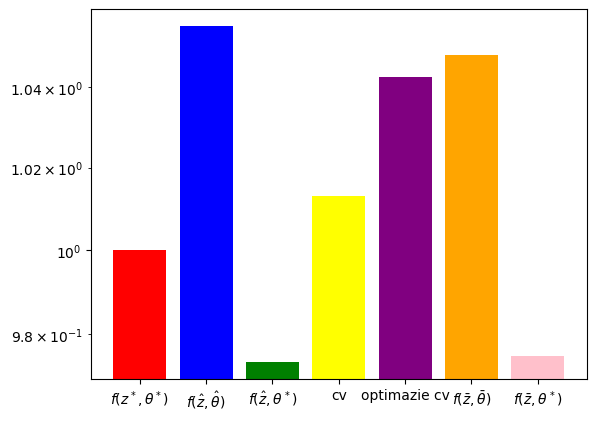

In [49]:
# 結果を棒グラフに出力
date_list = [
    so_salse_mean,
    po_salse_mean,
    true_po_salse_mean,
    cv_salse_mean,
    ebz_val_mean,
    ebz_po_salse_mean,
    true_ebz_po_salse_mean,
]
# 色の指定
colors = ["red", "blue", "green", "yellow", "purple", "orange", "pink"]

plt.bar(label_list, date_list, color=colors)

plt.yscale("log")
plt.show()

In [50]:
for i in range(10):
    print(true_po_salse_list[i], true_ebz_po_salse_list[i])
    print(true_po_salse_list[i] < true_ebz_po_salse_list[i])


0.9972346663024064 0.9796396993796397
False
0.9880121975468739 0.9844253903158174
False
0.9962793475872413 0.9870856726335521
False
0.8869048968652798 0.9324626493366117
True
0.9539021838982634 0.970838362146604
True
0.9981643984234768 0.9995238688257077
True
0.9984491438154035 0.9963681429342637
False
0.9455854246728724 0.9339610385331709
False
0.9896787289568587 0.9925936793379387
True
0.9799319491442037 0.9725916706495252
False


In [51]:
true_po_salse_mean, true_ebz_po_salse_mean

(0.973414293721288, 0.9749490174092831)

In [78]:
M = 15
N = 500
K = 5
r_min = 0.6
r_max = 1.0
r_mean = 0.8
r_std = 0.1

lb, ub, bounds, default_bounds = create_bounds(M, r_min, r_max)

so_salse_list = []
po_salse_list = []
true_po_salse_list = []
cv_salse_list = []
ebz_val_list = []
ebz_po_salse_list = []
true_ebz_po_salse_list = []
for _ in range(10):
    # データ作成
    alpha, beta, X, Y = create_date(M, N, r_mean, r_std, delta=0.6)
    # 最適化
    so_sales, so_prices = sales_optimize(M, alpha, beta, default_bounds)
    po_sales, po_prices = predict_optimize(M, X, Y, default_bounds)
    true_po_sales = sum(sales_function(po_prices, alpha, beta))
    cv_sales = cross_validation(X, Y, M, K, default_bounds)

    print("so", so_prices)
    print("po", po_prices)
    print(so_prices == po_prices)

    ebz_val, ebz_bounds = estimate_bounds_zero_nelder(
        bounds, M, X, Y, K, r_min, r_max, adaptive=True
    )
    ebz_po_sales, ebz_po_prices = predict_optimize(M, X, Y, ebz_bounds)
    true_ebz_po_sales = sum(sales_function(ebz_po_prices, alpha, beta))

    print(ebz_po_prices == po_prices)
    print(ebz_po_prices == so_prices)

    so_salse_list.append(so_sales / so_sales)
    po_salse_list.append(po_sales / so_sales)
    true_po_salse_list.append(true_po_sales / so_sales)
    cv_salse_list.append(cv_sales / so_sales)
    ebz_val_list.append(ebz_val / so_sales)
    ebz_po_salse_list.append(ebz_po_sales / so_sales)
    true_ebz_po_salse_list.append(true_ebz_po_sales / so_sales)


so_salse_mean = np.mean(so_salse_list)
po_salse_mean = np.mean(po_salse_list)
true_po_salse_mean = np.mean(true_po_salse_list)
cv_salse_mean = np.mean(cv_salse_list)
ebz_val_mean = np.mean(ebz_val_list)
ebz_po_salse_mean = np.mean(ebz_po_salse_list)
true_ebz_po_salse_mean = np.mean(true_ebz_po_salse_list)


so [0.75389804 0.75590735 1.         1.         0.8602435  0.9517068
 0.6        0.82709583 0.68722337 0.6        1.         0.6
 0.97849927 0.95057583 0.68294331]
po [0.6        0.8303108  0.72946989 1.         1.         1.
 0.6        0.82174719 0.6        0.6        0.7947562  0.6
 1.         1.         0.6       ]
[False False False  True False False  True False False  True False  True
 False False False]
[False False False False False False False False False False False False
 False False  True]
[False False False False False False False False False False False False
 False False False]
so [0.6        0.6        0.65657196 0.6        0.6        0.6
 0.6        0.73340855 0.6        0.6        0.6        0.6
 0.89226554 0.65145279 0.6       ]
po [0.6        0.6319773  0.66664966 0.6        0.6        0.6
 0.6        0.71093871 0.6        0.6        0.61761351 0.65300693
 0.785406   0.68516363 0.65055437]
[ True False False  True  True  True  True False  True  True False False
 Fal

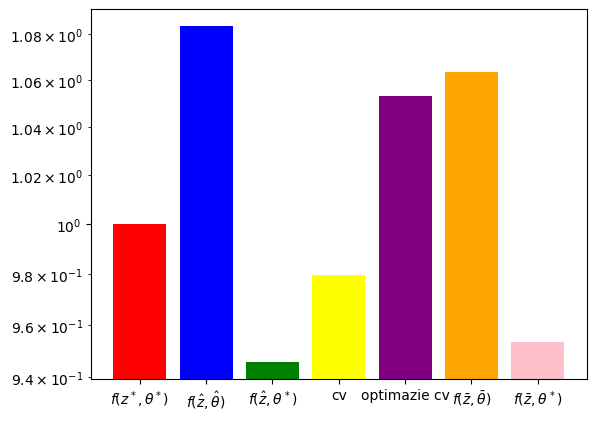

In [80]:
label_list = [
    r"$f(z^*,\theta^*)$",
    r"$f(\hat{z},\hat\theta)$",
    r"$f(\hat{z},\theta^*)$",
    r"cv",
    r"optimazie cv",
    r"$f(\bar{z},\bar\theta)$",
    r"$f(\bar{z},\theta^*)$",
]
# 結果を棒グラフに出力
date_list = [
    so_salse_mean,
    po_salse_mean,
    true_po_salse_mean,
    cv_salse_mean,
    ebz_val_mean,
    ebz_po_salse_mean,
    true_ebz_po_salse_mean,
]

colors = ["red", "blue", "green", "yellow", "purple", "orange", "pink"]

plt.bar(label_list, date_list, color=colors)
plt.yscale("log")
plt.show()


In [81]:
for i in range(10):
    print(true_po_salse_list[i], true_ebz_po_salse_list[i])
    print(true_po_salse_list[i] < true_ebz_po_salse_list[i])


0.9705074424530158 0.9717945457018305
True
0.9881687494591888 0.9665159690178609
False
0.9716081077236052 0.9718989765781997
True
0.9492262394672902 0.9625573353460272
True
0.9208726935949088 0.9421377692867184
True
0.9320481595726495 0.9523723322342568
True
0.9303281075767418 0.951434794509332
True
0.921735056706988 0.9321954493106014
True
0.890469566481401 0.9185857691084348
True
0.9827096143829199 0.9677760516801879
False


In [82]:
M = 20
N = 500
K = 5
r_min = 0.6
r_max = 1.0
r_mean = 0.8
r_std = 0.1

lb, ub, bounds, default_bounds = create_bounds(M, r_min, r_max)

so_salse_list = []
po_salse_list = []
true_po_salse_list = []
cv_salse_list = []
ebz_val_list = []
ebz_po_salse_list = []
true_ebz_po_salse_list = []
for _ in range(10):
    # データ作成
    alpha, beta, X, Y = create_date(M, N, r_mean, r_std, delta=0.6)
    # 最適化
    so_sales, so_prices = sales_optimize(M, alpha, beta, default_bounds)
    po_sales, po_prices = predict_optimize(M, X, Y, default_bounds)
    true_po_sales = sum(sales_function(po_prices, alpha, beta))
    cv_sales = cross_validation(X, Y, M, K, default_bounds)

    print("so", so_prices)
    print("po", po_prices)
    print(so_prices == po_prices)

    ebz_val, ebz_bounds = estimate_bounds_zero_nelder(
        bounds, M, X, Y, K, r_min, r_max, adaptive=True
    )
    ebz_po_sales, ebz_po_prices = predict_optimize(M, X, Y, ebz_bounds)
    true_ebz_po_sales = sum(sales_function(ebz_po_prices, alpha, beta))

    print(ebz_po_prices == po_prices)
    print(ebz_po_prices == so_prices)

    so_salse_list.append(so_sales / so_sales)
    po_salse_list.append(po_sales / so_sales)
    true_po_salse_list.append(true_po_sales / so_sales)
    cv_salse_list.append(cv_sales / so_sales)
    ebz_val_list.append(ebz_val / so_sales)
    ebz_po_salse_list.append(ebz_po_sales / so_sales)
    true_ebz_po_salse_list.append(true_ebz_po_sales / so_sales)


so_salse_mean = np.mean(so_salse_list)
po_salse_mean = np.mean(po_salse_list)
true_po_salse_mean = np.mean(true_po_salse_list)
cv_salse_mean = np.mean(cv_salse_list)
ebz_val_mean = np.mean(ebz_val_list)
ebz_po_salse_mean = np.mean(ebz_po_salse_list)
true_ebz_po_salse_mean = np.mean(true_ebz_po_salse_list)


so [0.71234637 0.80663366 0.81220633 0.63138067 0.9786612  0.9409812
 0.60995958 0.74443722 0.64454057 0.81287819 0.86236909 0.76259649
 0.64631017 0.6        0.64770397 0.61933375 0.6        0.89367145
 0.81548661 0.6       ]
po [0.68276646 0.78170504 1.         0.6        0.95545847 1.
 0.6        0.86369946 0.92355806 0.69557221 1.         0.6
 0.6        0.6        0.64550777 0.6        0.6        1.
 0.84712904 0.6       ]
[False False False False False False False False False False False False
 False  True False False  True False False  True]
[False False False False False False False False False False False False
 False False False False False  True False False]
[False False False False False False False False False False False False
 False False False False False False False False]
so [0.85830368 0.7226859  0.99083438 0.6        0.6        0.6
 0.6        0.80068497 1.         0.6665383  0.6497139  0.6
 0.6        0.69350384 1.         0.85547826 0.6        0.60294875
 0.6     

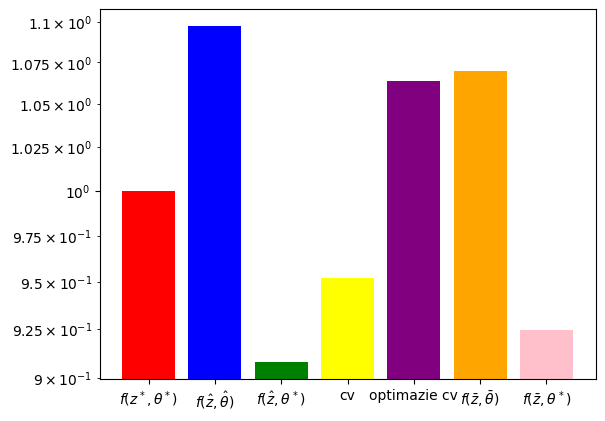

In [83]:
label_list = [
    r"$f(z^*,\theta^*)$",
    r"$f(\hat{z},\hat\theta)$",
    r"$f(\hat{z},\theta^*)$",
    r"cv",
    r"optimazie cv",
    r"$f(\bar{z},\bar\theta)$",
    r"$f(\bar{z},\theta^*)$",
]
# 結果を棒グラフに出力
date_list = [
    so_salse_mean,
    po_salse_mean,
    true_po_salse_mean,
    cv_salse_mean,
    ebz_val_mean,
    ebz_po_salse_mean,
    true_ebz_po_salse_mean,
]

plt.bar(label_list, date_list, color=colors)
plt.yscale("log")
plt.show()


In [84]:
for i in range(10):
    print(true_po_salse_list[i], true_ebz_po_salse_list[i])
    print(true_po_salse_list[i] < true_ebz_po_salse_list[i])


0.9655194984671098 0.9702077621141427
True
0.9005682231381303 0.8881014813926027
False
0.8735071962839606 0.9045586924809306
True
0.8339653670149512 0.8669214591535009
True
0.8956584342969137 0.9366104173086292
True
0.945778782506109 0.9501677154551971
True
0.9343528728364743 0.9434910021780399
True
0.9200341823989039 0.958501581884646
True
0.9295847219286094 0.9357723181333475
True
0.8793547808748092 0.8913121940952521
True
